In [1]:
import pandas as pd 
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import os 
from sklearn.decomposition import PCA

In [2]:
full_df = pd.read_csv("../data/full_df.csv")

In [7]:
full_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [3]:
df = full_df.drop_duplicates(subset='ID', keep='first').sort_values(by="ID")


In [9]:
df.shape

(3358, 19)

In [4]:
df = df[df[['N', 'D', 'G', "C",'A', 'H', 'M', 'O']].sum(axis=1)==1]

In [11]:
df.shape

(2802, 19)

In [12]:
df[df['ID'] == 3]

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
3196,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3_left.jpg


In [75]:
output_folder = "data/combined"
img_folder = "data/2"
os.makedirs(output_folder, exist_ok=True)

In [86]:
for idx, row in df.iterrows():
    ID = str(row['ID'])
    left_img_path = os.path.join(img_folder, row['Left-Fundus'])
    right_img_path = os.path.join(img_folder, row['Right-Fundus'])
    
    try:
        target = (512, 512)
        
        # Open and resize the images
        left = Image.open(left_img_path).convert('RGB').resize(target)
        right = Image.open(right_img_path).convert('RGB').resize(target)
        
        # Create a new image and paste the two images side by side
        combined = Image.new('RGB', (1024, 512))
        combined.paste(left, (0, 0))
        combined.paste(right, (512, 0))

        # Save as {ID}_eyes.jpg
        out_path = os.path.join(output_folder, f"{ID}_eyes.jpg")
        combined.save(out_path)

    except Exception as e:
        print(f"Error processing ID {ID}: {e}")


In [87]:
#turn 1024 x 512 x 3 -> 1024 x 512 x 1 with black and white gray scale 
img_path = "data/combined/3_eyes.jpg"
img = Image.open(img_path).convert('RGB')
width, height = img.size
print(width, height)

1024 512


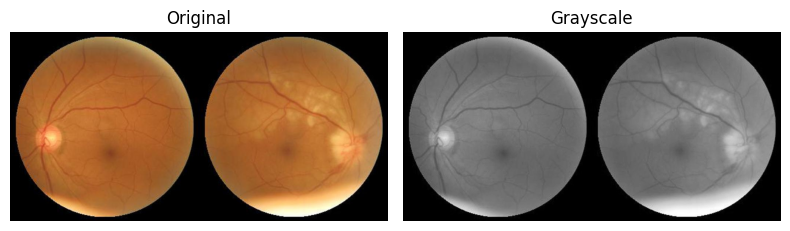

In [88]:

img_array = np.asarray(img)
grayscale = rgb2gray(img_array)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(img)
ax[0].set_title("Original")
ax[0].axis('off')

ax[1].imshow(grayscale, cmap='gray')
ax[1].set_title("Grayscale")
ax[1].axis('off')

fig.tight_layout()
plt.show()

In [5]:
df = df[['ID', 'N', 'D', 'G','C', 'A', 'H', 'M', 'O', 'labels', 'target']]
df['image'] = df['ID'].astype(str) + '_eyes.jpg'

In [6]:
df.head()

,ID,N,D,G,C,A,H,M,O,labels,target,image
0,0,0,0,0,1,0,0,0,0,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_eyes.jpg
1,1,1,0,0,0,0,0,0,0,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_eyes.jpg
3196,3,0,0,0,0,0,0,0,1,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3_eyes.jpg
4,5,0,1,0,0,0,0,0,0,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_eyes.jpg
7,8,1,0,0,0,0,0,0,0,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_eyes.jpg


Data has two conflicting markers. 

For example, in the table above ID 0 has a 1 in the column for cataract but the label for normal. 

We make a second target column labeled target2 based on the N-O columns. 

Dictionary reference: 

[N = 0, D = 1, G = 2, C = 3, A = 4, H = 5, M = 6, O = 7]


In [7]:
df['target2'] = df[['N', 'D', 'G','C', 'A', 'H','M', 'O']].values.tolist()

In [8]:
df.head()

,ID,N,D,G,C,A,H,M,O,labels,target,image,target2
0,0,0,0,0,1,0,0,0,0,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_eyes.jpg,"[0, 0, 0, 1, 0, 0, 0, 0]"
1,1,1,0,0,0,0,0,0,0,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_eyes.jpg,"[1, 0, 0, 0, 0, 0, 0, 0]"
3196,3,0,0,0,0,0,0,0,1,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3_eyes.jpg,"[0, 0, 0, 0, 0, 0, 0, 1]"
4,5,0,1,0,0,0,0,0,0,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_eyes.jpg,"[0, 1, 0, 0, 0, 0, 0, 0]"
7,8,1,0,0,0,0,0,0,0,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_eyes.jpg,"[1, 0, 0, 0, 0, 0, 0, 0]"


In [9]:
#df.to_csv("ltp_df.csv")

# PCA

In [10]:
image_files = df['image']

In [16]:
N = len(df) #2802
sample_img = Image.open("../data/combined/" + image_files[0]).convert('RGB')
img_array = np.asarray(sample_img, dtype=np.float32) / 255.0
flattened_size = img_array.size
print(N,flattened_size)
#flattened size = 1024*512*3
images_array = np.zeros((N, flattened_size), dtype=np.float32)

2802 1572864


In [17]:
for i, file in enumerate(image_files):
    img = Image.open("../data/combined/" + file).convert('RGB')
    img_array = np.asarray(img, dtype=np.float32) / 255.0
    images_array[i, :] = img_array.flatten()

In [18]:

pca = PCA(n_components = 2)
X_pca = pca.fit_transform(images_array)

In [19]:
class_cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

In [20]:
y = df[class_cols].values.argmax(axis=1)

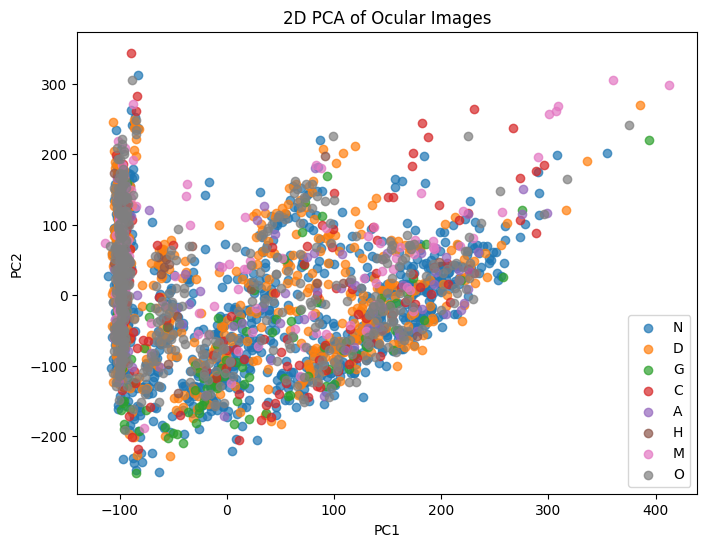

In [22]:

plt.figure(figsize=(8, 6))
for i, label in enumerate(class_cols):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], label=label, alpha=0.7)

plt.title("2D PCA of Ocular Images")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

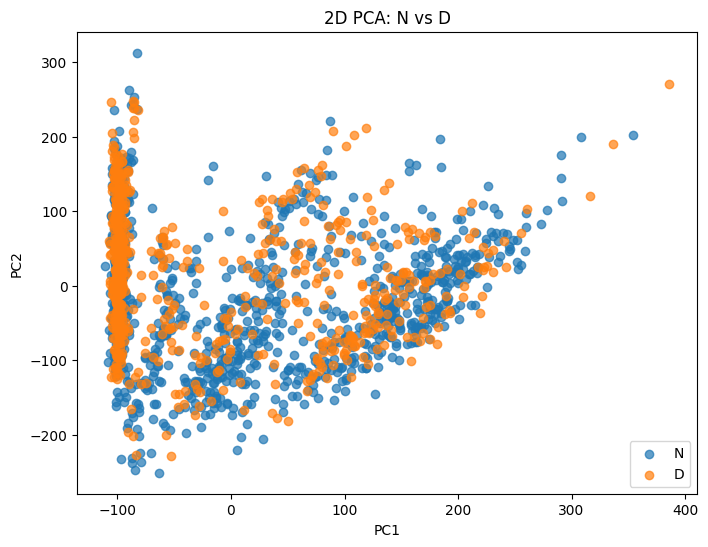

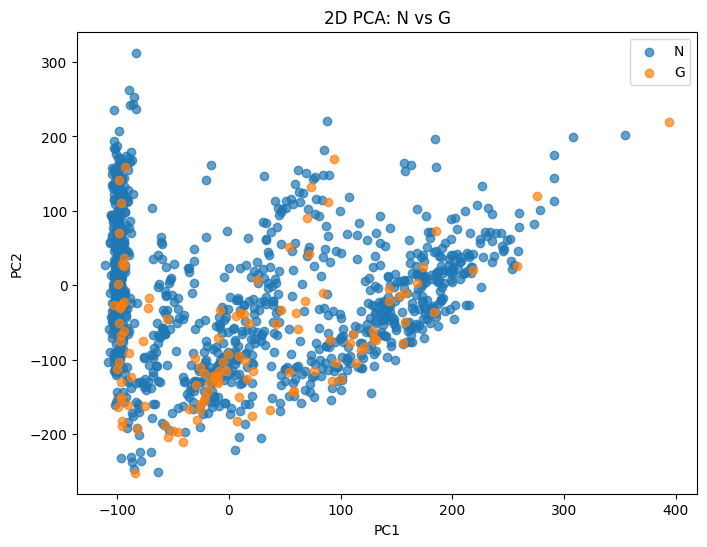

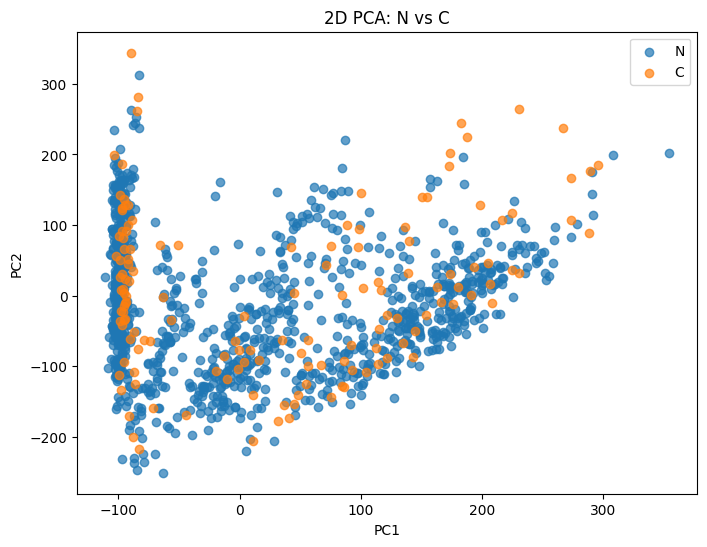

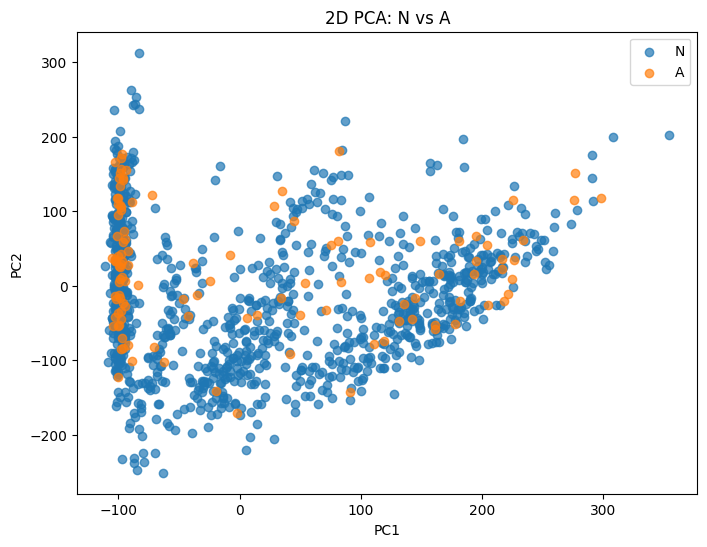

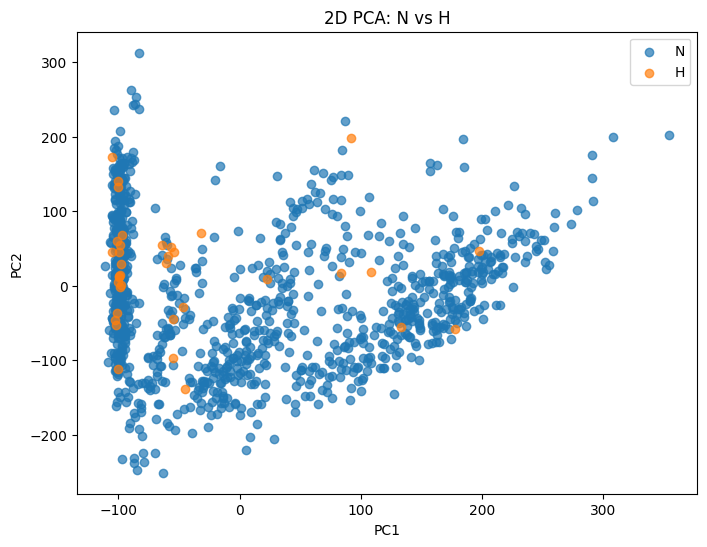

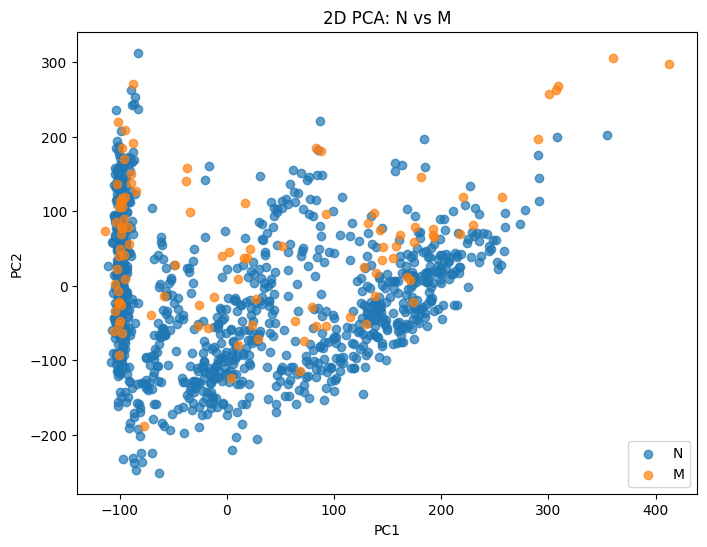

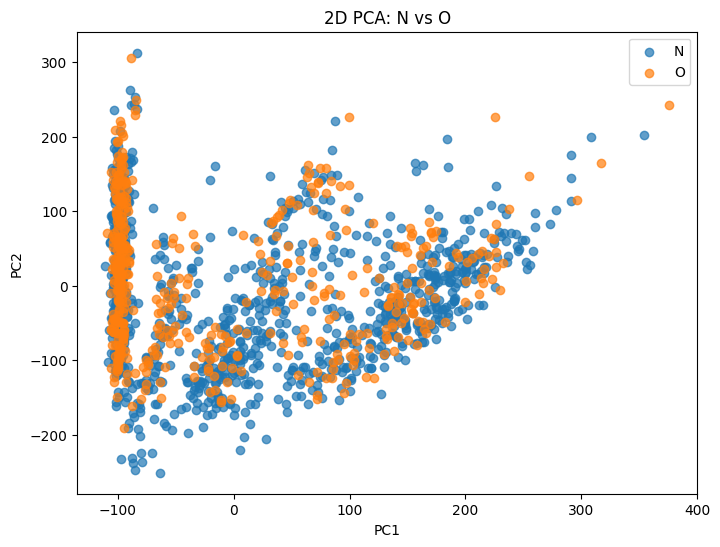

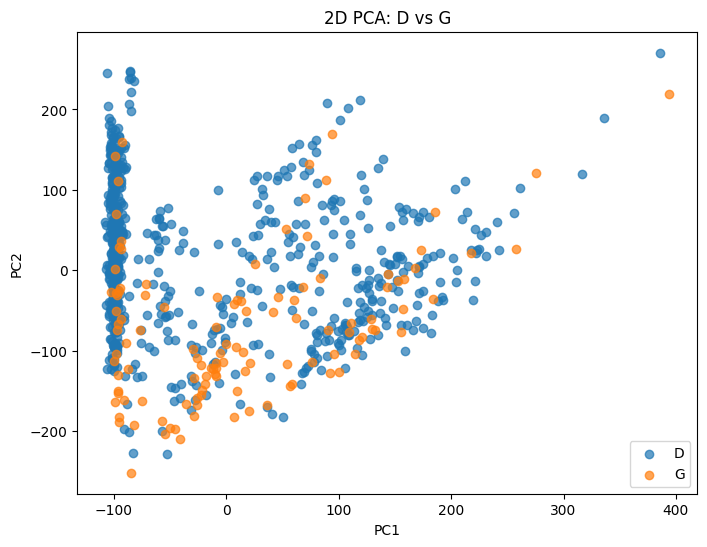

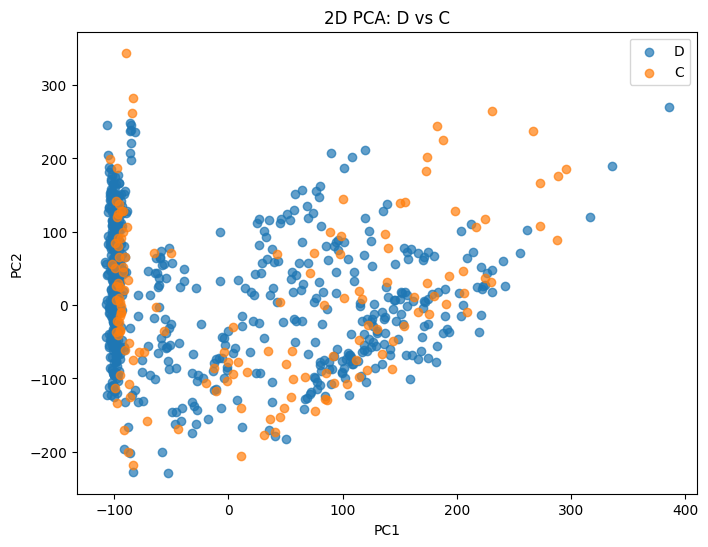

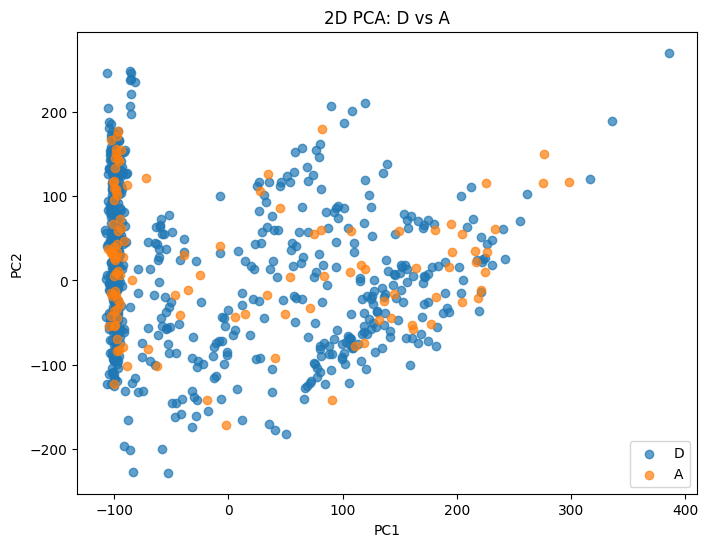

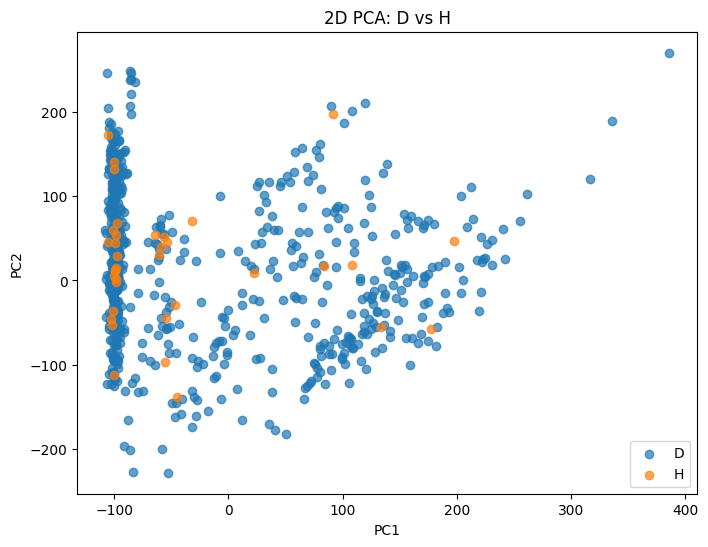

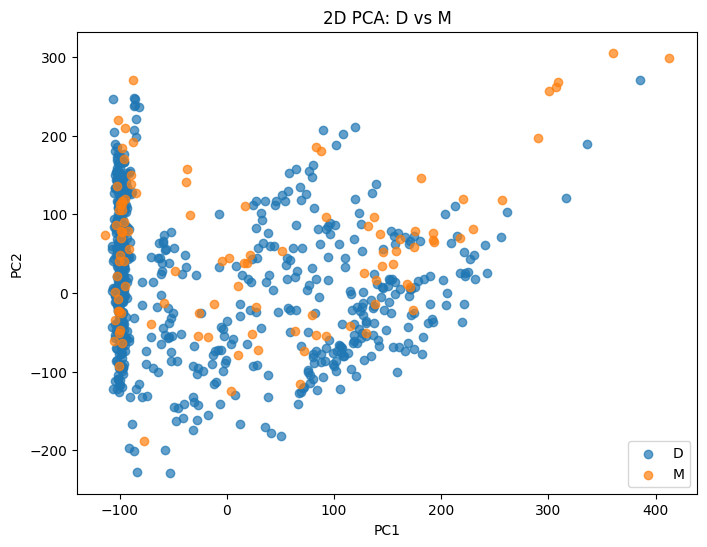

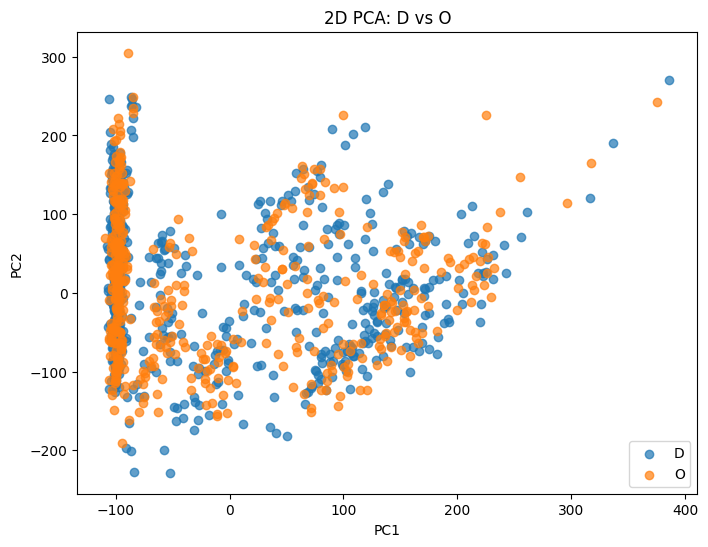

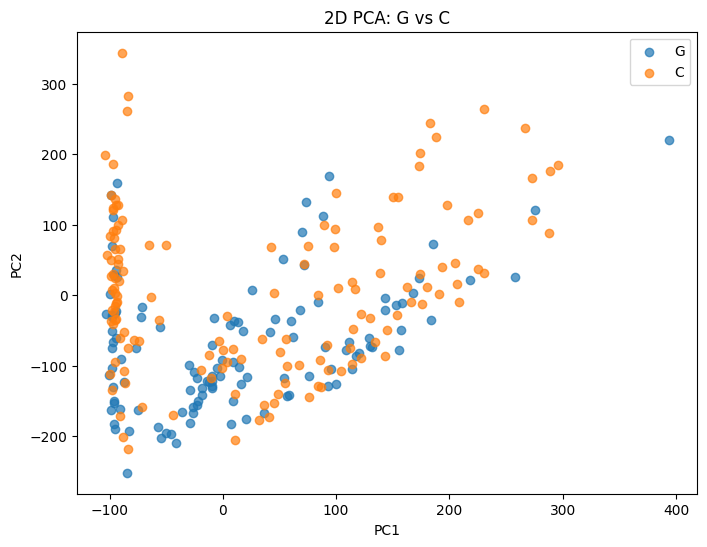

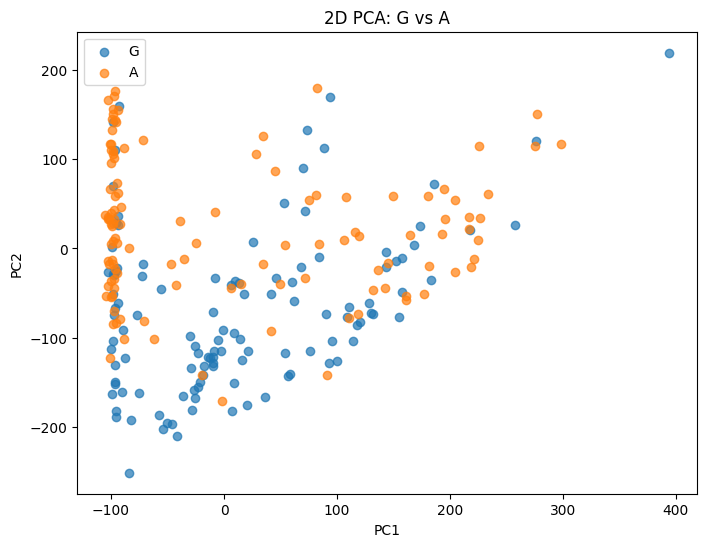

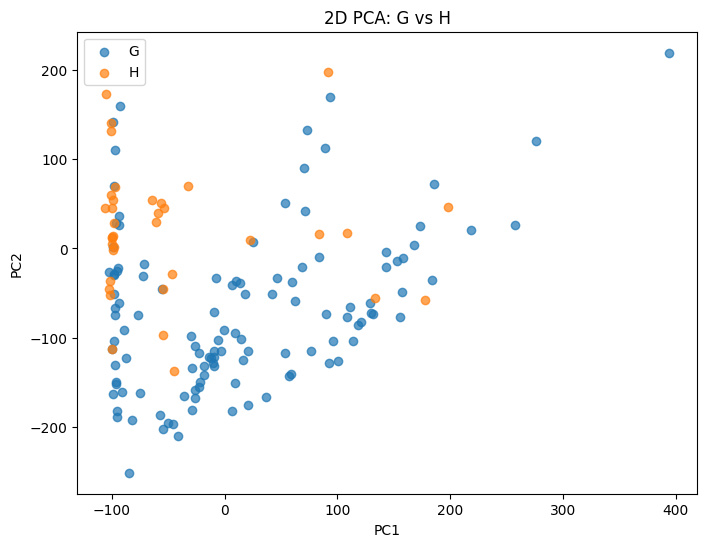

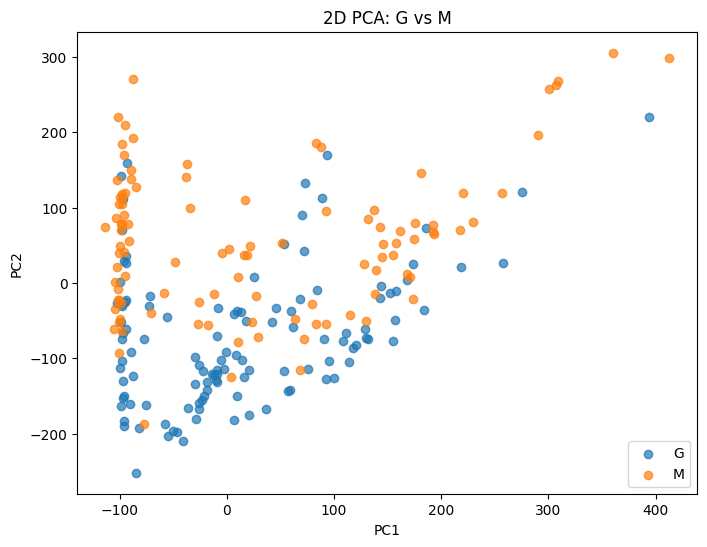

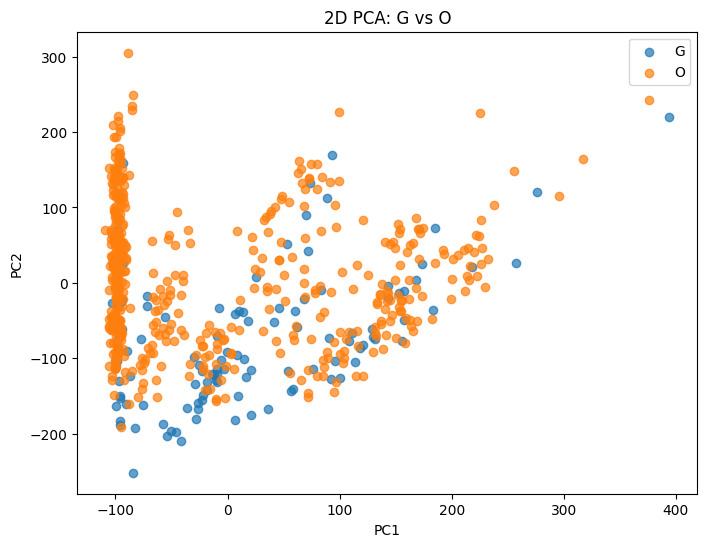

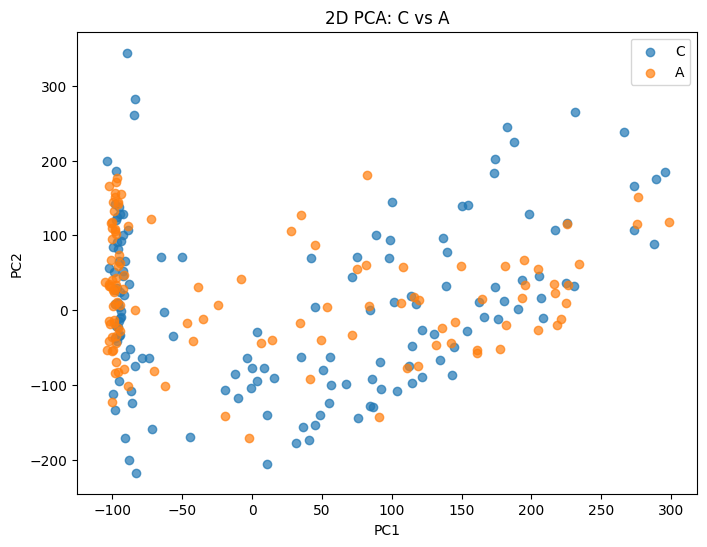

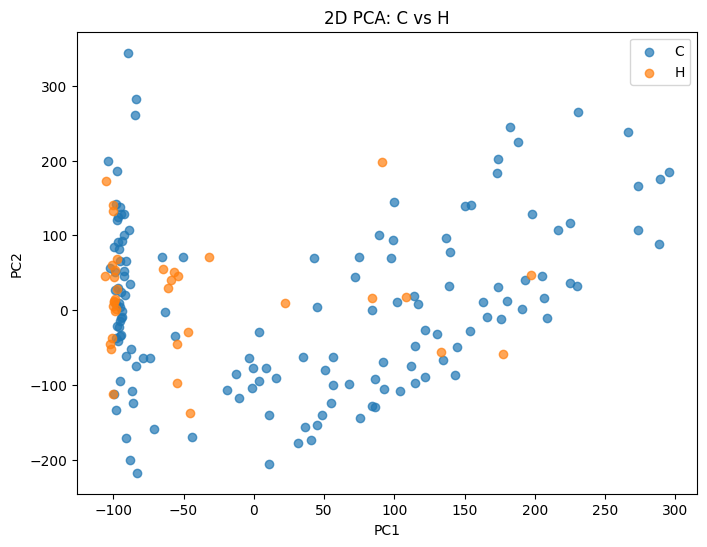

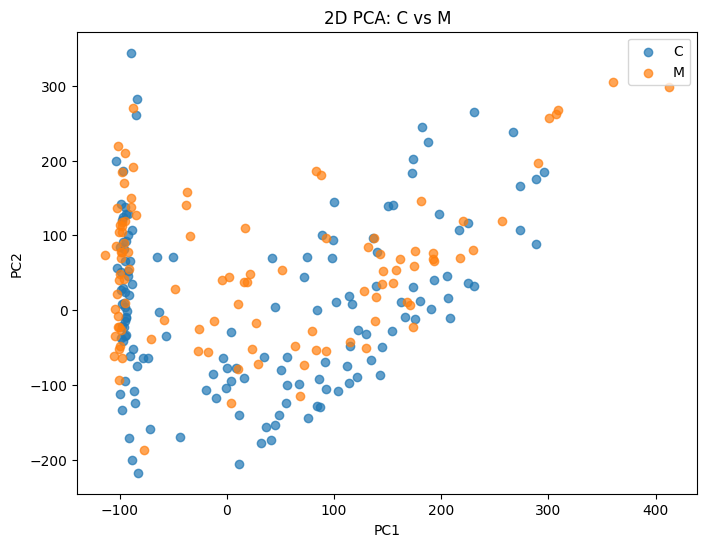

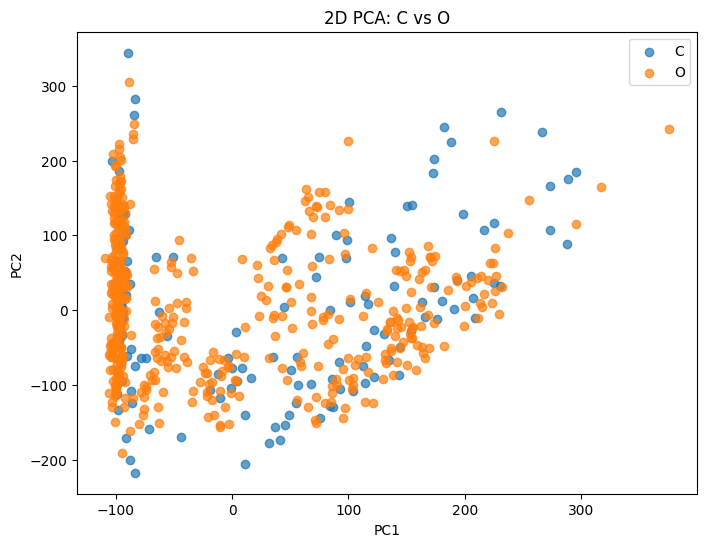

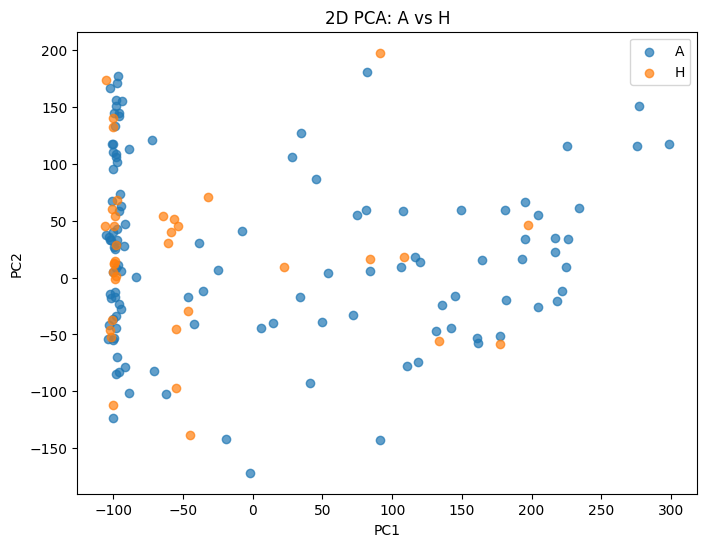

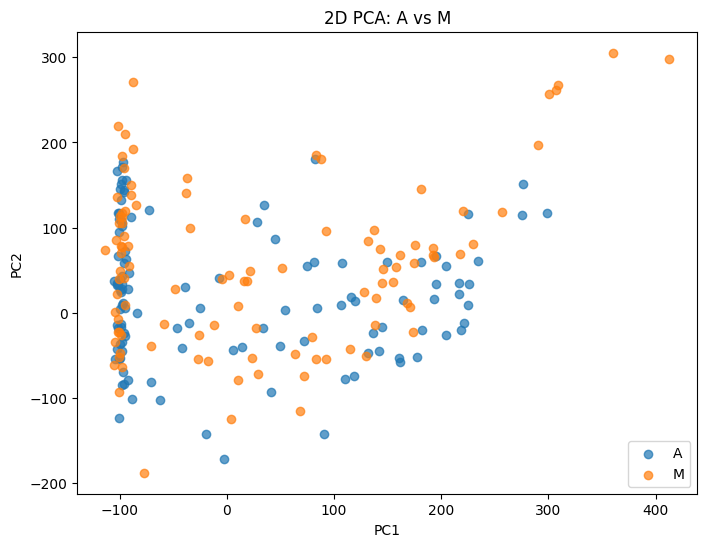

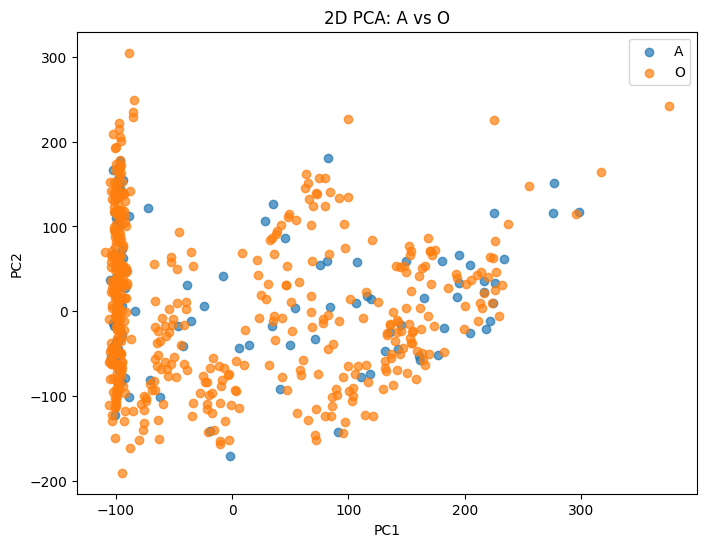

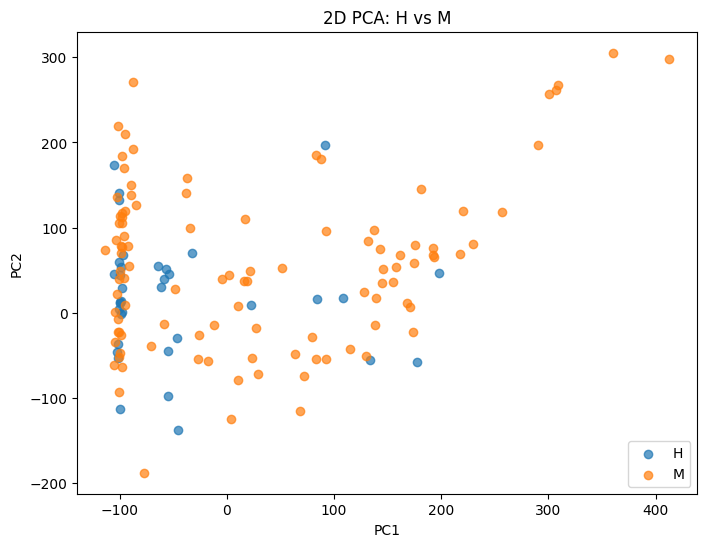

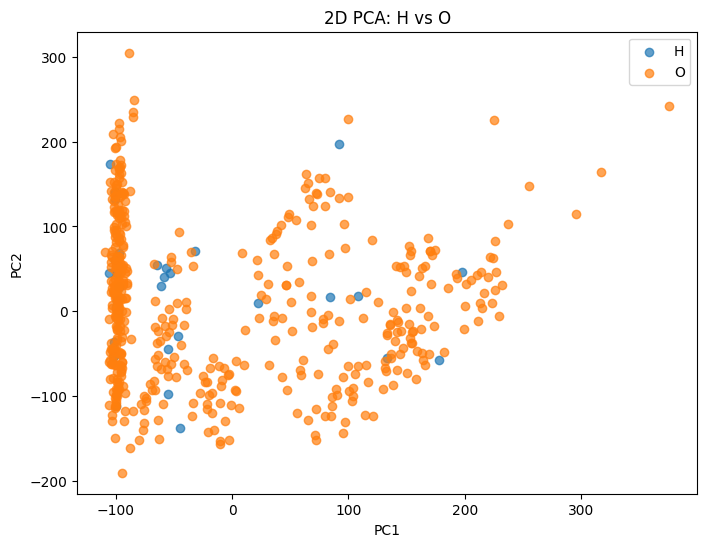

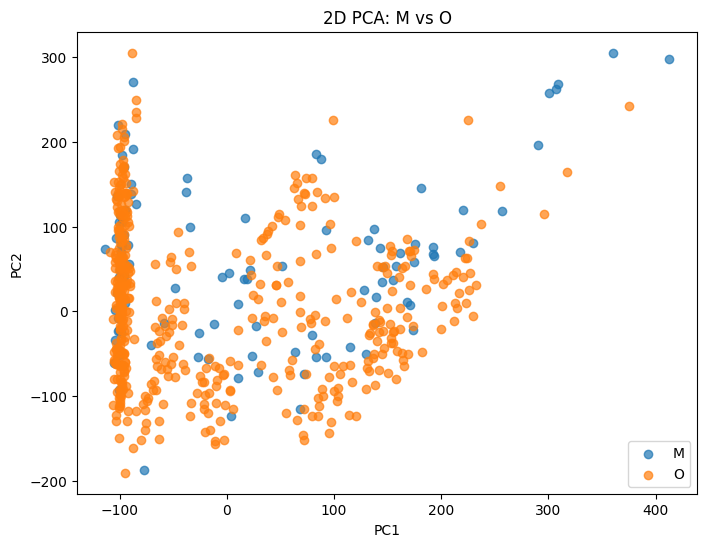

In [23]:
import itertools
import matplotlib.pyplot as plt

# Get all pairs of class indices
pairs = list(itertools.combinations(range(len(class_cols)), 2))

for (i, j) in pairs:
    plt.figure(figsize=(8, 6))

    # Mask for the two classes
    mask = (y == i) | (y == j)

    # Plot only points belonging to class i and j
    plt.scatter(X_pca[(y == i), 0], X_pca[(y == i), 1], label=class_cols[i], alpha=0.7)
    plt.scatter(X_pca[(y == j), 0], X_pca[(y == j), 1], label=class_cols[j], alpha=0.7)

    plt.title(f"2D PCA: {class_cols[i]} vs {class_cols[j]}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.show()
